In [1]:
# http://sgjp.pl/morfeusz/dopobrania.html.en
# https://bulldogjob.pl/news/650-przeglad-pakietu-datatable-pythona

In [2]:
selected_labels = ['rage_cat']
selected_features = ['title', 'media_desc', 'highlight', 'division']
normalize_emotion_label = 'multiply'

In [3]:
import pandas as pd
from unidecode import unidecode
from collections import Counter
import numpy as np

In [4]:
articles = pd.read_csv('data/processed_articles.csv', nrows = 20000)

In [5]:
articles.head(1)

,content,division,highlight,media_desc,title,url
0,najwyzsza izba kontroli zwraca uwage problem z...,zus emerytura,tysiace polakow zanizone emerytury wystapilo z...,osob maja dopisanych skladek emerytalnych czas...,nik alarmuje polacy maja zanizone emerytury,"http://wyborcza.biz/biznes/7,147880,23632593,n..."


In [6]:
len(articles)

19087

In [7]:
articles = articles.dropna()

In [8]:
len(articles)

19056

## Prepare input for model

In [9]:
def concat_x_string(columns):
    a = pd.Series('', index = articles.index)
    for column in columns:
        a = a + articles[column] + ' '
    return a.str.strip().str.split(' ').values

##### Chose columns for model input

In [10]:
string_columns = concat_x_string(selected_features)

In [11]:
string_columns[1]

['katalonia',
 'premiera',
 'parlament',
 'barcelonie',
 'przeglosowal',
 'kandydature',
 'secesjonisty',
 'quima',
 'torry',
 'parlament',
 'barcelonie',
 'zatwierdzil',
 'quima',
 'torre',
 'nowego',
 'premiera',
 'katalonii',
 'maja',
 'r',
 'nowy',
 'premier',
 'obiecuje',
 'dazyc',
 'oderwania',
 'katalonii',
 'reszty',
 'kraju',
 'samo',
 'poprzednik',
 'carles',
 'puigdemont',
 'rzad',
 'hiszpanii',
 'patrzyl',
 'rece',
 'swiat']

In [12]:
idf = dict(Counter([word for content in string_columns for word in content]))

In [13]:
filtered_idf = {word: freq for word, freq in idf.items() if freq > len(articles) * 0.003}

##### Ignore words which appear very rare - they won't be very useful (and dataset won't fit into my ram)

In [14]:
# I want only words which appear in number of 0.1% times number of articles
def filter_not_frequent(string_columns, filtered_idf):
    filtered = []
    for record in string_columns:
        filtered.append([word for word in record if word in filtered_idf.keys()])
    return filtered

In [15]:
filtered = filter_not_frequent(string_columns, filtered_idf)

In [16]:
filtered[1]

['premiera',
 'parlament',
 'parlament',
 'nowego',
 'premiera',
 'maja',
 'r',
 'nowy',
 'premier',
 'obiecuje',
 'kraju',
 'samo',
 'rzad',
 'hiszpanii',
 'rece',
 'swiat']

In [17]:
unique_words = list(set(filtered_idf.keys()))
vocab_size = len(unique_words)

In [18]:
vocab_size

1934

In [19]:
word2int = {}
int2word = {}

for i,word in enumerate(unique_words):
    word2int[word] = i
    int2word[i] = word

##### Change words to vectors

In [20]:
def string_x_to_tf_idf(records, idf, vocab_size, word2int):
    dataset = []
    for record in records:
        tmp_vector = np.zeros(vocab_size)
        for word, counter in Counter(record).items():
            tmp_vector[word2int[word]] = counter / idf[word]
        dataset.append(tmp_vector)
    
    return np.asarray(dataset)

In [21]:
x = string_x_to_tf_idf(filtered, filtered_idf, vocab_size, word2int)

In [22]:
len(x)

19056

In [23]:
len(articles['url'])

19056

## Prepare labels

In [24]:
from labeling.emotions import rage, joy, sadness, surprise, fear, all_flag_words

In [25]:
comments_raw = pd.concat([
    pd.read_csv('data/processed_comments_1.csv'),
    pd.read_csv('data/processed_comments_2.csv')
])[['url', 'downvotes', 'upvotes', 'words']]

In [26]:
comments_raw.head(1)

,url,downvotes,upvotes,words
0,"http://wyborcza.biz/biznes/7,147880,23632593,n...",0,10,"['brak', 'kwartalnych', 'waloryzacji', 'kapita..."


In [27]:
comment_emotions = []
for comment in comments_raw['words'].values:
    record_labels = [0, 0, 0, 0, 0, 0]
    eval_comment = eval(comment)
    
    for i, emotion in enumerate([rage, joy, sadness, surprise, fear]):
        for flag_word in emotion:
            if flag_word in eval_comment:
                record_labels[i] += 1
        if record_labels[i] != 0:
            record_labels[5] += 1
                
    comment_emotions.append(record_labels)

In [28]:
emotions_df = pd.DataFrame(comment_emotions, index = comments_raw.index)
emotions_df.columns = ['rage', 'joy', 'sadness', 'surprise', 'fear', 'emotions_count']

In [29]:
comments = pd.concat([comments_raw, emotions_df], axis = 1).drop('words', axis = 1)

In [30]:
comments[comments['url'] == 'http://bialystok.wyborcza.pl/bialystok/7,35241,23042200,komorowski-budowanie-dumy-z-polskiej-historii-konczy-sie-wstydem.html']

,url,downvotes,upvotes,rage,joy,sadness,surprise,fear,emotions_count
221003,"http://bialystok.wyborcza.pl/bialystok/7,35241...",2,14,0,0,0,0,0,0
221004,"http://bialystok.wyborcza.pl/bialystok/7,35241...",9,6,0,0,0,0,0,0
221005,"http://bialystok.wyborcza.pl/bialystok/7,35241...",8,1,0,0,0,0,0,0
221006,"http://bialystok.wyborcza.pl/bialystok/7,35241...",1,4,0,0,0,0,0,0


In [31]:
sums = comments\
    .groupby('url')\
    .sum()

In [32]:
counts = comments\
    [['url', 'downvotes']]\
    .groupby('url')\
    .count()
counts.columns = ['replies']

In [33]:
labels = pd.concat([counts, sums], axis = 1)\
    .reindex(articles['url'])\
    .reset_index()\
    .drop('url', axis = 1)

In [34]:
labels['reactions'] = labels['upvotes'] + labels['downvotes']

In [35]:
len(labels)

19056

In [36]:
labels.head(1)

,replies,downvotes,upvotes,rage,joy,sadness,surprise,fear,emotions_count,reactions
0,2.0,0.0,11.0,0.0,0.0,0.0,0.0,0.0,0.0,11.0


In [37]:
# Remove extreme values
labels.loc[labels['replies'] > 200, 'replies'] = 200
labels.loc[labels['downvotes'] > 500, 'downvotes'] = 500
labels.loc[labels['upvotes'] > 4000, 'upvotes'] = 4000
labels.loc[labels['reactions'] > 4500, 'reactions'] = 4500

In [38]:
# Add categorized labels
labels.loc[labels['replies'] < 7, 'replies_cat'] = 0
labels.loc[(labels['replies'] <= 25)&(labels['replies'] >= 7), 'replies_cat'] = 1
labels.loc[labels['replies'] > 25, 'replies_cat'] = 2

labels.loc[labels['reactions'] < 30, 'reactions_cat'] = 0
labels.loc[(labels['reactions'] <= 200)&(labels['reactions'] >= 30), 'reactions_cat'] = 1
labels.loc[labels['reactions'] > 200, 'reactions_cat'] = 2

labels.loc[labels['rage'] > 0 , 'rage_cat'] = 1
labels.loc[labels['rage'] == 0, 'rage_cat'] = -1

In [39]:
if selected_labels[0] in ['rage_cat']:
    if normalize_emotion_label == 'cut':
        l = len(labels[labels[selected_labels[0]] == 1])
        labels = pd.concat([
            labels[labels[selected_labels[0]] == 1],
            labels[labels[selected_labels[0]] == -1].iloc[:l]
        ])
    elif normalize_emotion_label == 'multiply':
        m = int(len(labels[labels[selected_labels[0]] != 1])/len(labels[labels[selected_labels[0]] == 1]))
        labels = pd.concat([
            labels[labels[selected_labels[0]] == 1] for x in range(m)
        ] + [labels[labels[selected_labels[0]] == -1]])

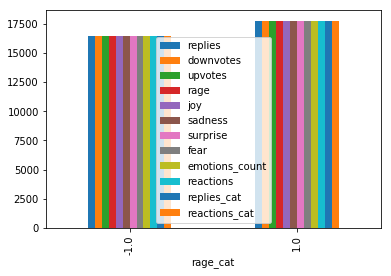

In [41]:
labels\
    .groupby(selected_labels[0])\
    .count()\
    .plot(kind = 'bar')

## Merge x and y

In [42]:
labels = labels.sample(frac=1)

In [43]:
labels_indices = labels[labels['reactions'].isna() == False].index.values

In [44]:
final_x = x[labels_indices]
final_y = labels[labels['reactions'].isna() == False]\
    [selected_labels]\
    .values

In [45]:
print(len(final_x), len(final_y))

34247 34247


In [46]:
print(final_x.shape, final_y.shape)

(34247, 1934) (34247, 1)


## Training

In [47]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.nn import relu

In [48]:
model = Sequential([
    Dense(vocab_size/50, activation=relu, input_shape=[vocab_size]),
    Dense(vocab_size/50, activation=relu),
    Dense(len(selected_labels))
])

W0625 21:56:15.250315 139741685847872 deprecation.py:506] From /home/jacek/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [49]:
from tensorflow.keras.optimizers import RMSprop

In [50]:
optimizer = RMSprop(0.003)

In [51]:
from tensorflow.losses import *

In [52]:
model.compile(
    loss=absolute_difference,
    optimizer=optimizer,
    metrics=['mean_absolute_error']
)

W0625 21:56:16.707741 139741685847872 deprecation.py:323] From /home/jacek/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/losses/losses_impl.py:121: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [53]:
b = int(0.9 * len(final_x))

In [54]:
train_x = final_x[:b]
train_y = final_y[:b]

test_x = final_x[b:]
test_y = final_y[b:]

In [55]:
example_batch = test_x[:5]
print(model.predict(example_batch))

[[ 0.00015688]
 [-0.00131115]
 [ 0.000307  ]
 [ 0.00080071]
 [-0.00023851]]


In [56]:
EPOCHS = 300

In [57]:
from tensorflow.keras.callbacks import EarlyStopping

In [58]:
early_stop = EarlyStopping(monitor='val_loss', patience=10)

In [59]:
history = model.fit(
    train_x, train_y,
    epochs=EPOCHS,
    validation_split = 0.2, 
    verbose=0,
    callbacks=[early_stop]
)

In [60]:
import pandas as pd
import matplotlib.pyplot as plt

In [61]:
def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error [MPG]')
    plt.plot(hist['epoch'], hist['mean_absolute_error'],
           label='Train Error')
    plt.plot(hist['epoch'], hist['val_mean_absolute_error'],
           label = 'Val Error')
    m = max(max([history.history['mean_absolute_error'] + history.history['val_mean_absolute_error']]))
    plt.ylim([0,m * 1.1])
    plt.legend()

In [62]:
loss, mae = model.evaluate(test_x, test_y, verbose=0)

In [63]:
mae

0.19836618

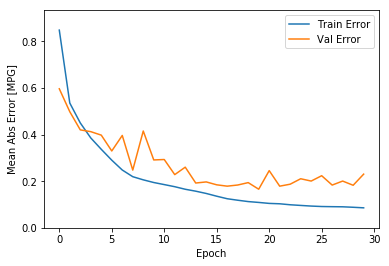

In [64]:
plot_history(history)

In [69]:
pred = model.predict(test_x)

In [70]:
res = pd.concat([pd.DataFrame(pred), pd.DataFrame(test_y)], axis = 1)

In [71]:
res.columns = ["pred_"+x for x in selected_labels] + ["real_"+x for x in selected_labels]

In [72]:
res.sample(frac=1).head(10)

,pred_rage_cat,real_rage_cat
994,1.002289,1.0
1398,1.001629,1.0
281,1.003012,1.0
441,-0.715285,-1.0
2664,1.002495,1.0
1554,1.002836,1.0
1193,1.002939,1.0
1651,-0.962589,-1.0
223,1.000890,1.0
29,-0.962589,-1.0
